In [125]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run o|r pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/server-logs-suspicious/CIDDS-001-external-week1.csv


In [126]:
dataset_csv_path ='/kaggle/input/server-logs-suspicious/'
csv_file_names = ['CIDDS-001-external-week1.csv']

In [127]:
# pd.read_csv: Reads a CSV file into a DataFrame.
# map(pd.read_csv, full_path): Applies the pd.read_csv function to each file path in the full_path list, resulting in a list of DataFrames.
# pd.concat(...): Concatenates the list of DataFrames into a single DataFrame.
# ignore_index=True: Resets the index of the resulting DataFrame.
full_path = []
for csv_file in csv_file_names:
    full_path.append(os.path.join(dataset_csv_path, csv_file))
df = pd.concat(map(pd.read_csv, full_path), ignore_index = True)
df.columns

Index(['Date first seen', 'Duration', 'Proto', 'Src IP Addr', 'Src Pt',
       'Dst IP Addr', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Flags', 'Tos',
       'class', 'attackType', 'attackID', 'attackDescription'],
      dtype='object')

In [128]:
def visualize_dataframe(df):
    """
    Display various visualizations and information about the dataframe.

    Parameters:
    - df: The dataframe to be visualized.
    """
    # Display first few rows in the dataframe
    print("First few rows in the dataframe:")
    print(df.head())

    # Checking for null value counts in each column 
    print (df.isnull().sum())
    
    # Display the shape of the dataframe
    print("\nThe shape of the dataframe:", df.shape)

    # Display data types of each feature in the dataframe
    print("\nData types of each feature:")
    df.info()

    # Display descriptive statistics for each feature in the dataframe
    print("\nThe descriptive statistics for each feature:")
    print(df.describe())

    # Display unique classes present in the dataset
    unique_classes = df['class'].unique()
    print("\nUnique classes present in the dataset:")
    print(unique_classes)
    
    return df

df = visualize_dataframe(df)

First few rows in the dataframe:
           Date first seen   Duration  Proto    Src IP Addr  Src Pt  \
0  2017-03-14 17:43:57.172  81412.697  TCP       EXT_SERVER    8082   
1  2017-03-14 17:43:57.172  81412.697  TCP    OPENSTACK_NET   56978   
2  2017-03-14 17:43:26.135  81504.787  TCP       EXT_SERVER    8082   
3  2017-03-14 17:43:26.135  81504.787  TCP    OPENSTACK_NET   56979   
4  2017-03-14 18:17:09.005  82100.692  TCP       EXT_SERVER    8082   

     Dst IP Addr   Dst Pt  Packets     Bytes  Flows   Flags  Tos   class  \
0  OPENSTACK_NET  56978.0     3057     2.1 M      1  .AP...    0  normal   
1     EXT_SERVER   8082.0     4748     2.5 M      1  .AP...    0  normal   
2  OPENSTACK_NET  56979.0     8639     9.1 M      1  .AP...    0  normal   
3     EXT_SERVER   8082.0    12024    10.3 M      1  .AP...    0  normal   
4  OPENSTACK_NET  51649.0    11012    27.2 M      1  .AP.S.    0  normal   

  attackType attackID attackDescription  
0        ---      ---               ---  

In [129]:
# Dataset Cleaning and Preprocessing Function
from itertools import combinations
import numpy as np

def data_preprocessing(df):
    """
    Perform cleaning and preprocessing on the given dataframe.

    Parameters:
    - df: The dataframe to be preprocessed.

    Returns:
    - df: The preprocessed and cleaned dataframe.
    """
    # Remove leading and trailing spaces in column names
    df.columns = df.columns.str.strip()

    # Set negative values to 0 in numeric columns
    num = df._get_numeric_data()
    num[num < 0] = 0

    # Drop columns with zero variance
    zero_variance_cols = [col for col in df.columns if len(df[col].unique()) == 1]
    df.drop(columns=zero_variance_cols, axis=1, inplace=True)
    print("Zero Variance Columns:", zero_variance_cols, " are dropped!!")
    print("Shape of dataframe after removing zero variance columns:", df.shape)

    # Replace infinite values with NaN and drop rows with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print(df.isna().any(axis=1).sum(), "NaN valued rows dropped")
    df.dropna(inplace=True)
    print("Shape of dataframe after Removing NaN:", df.shape)

    # Remove duplicate rows
    df.drop_duplicates(inplace=True)
    print("Shape of dataframe after dropping duplicate rows:", df.shape)

    # Drop columns with identical values
    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    identical_cols = [col_pair[1] for col_pair in column_pairs]
    df.drop(columns=identical_cols, axis=1, inplace=True)
    print("Columns with identical values:", column_pairs, "dropped!")
    print("Shape of dataframe after removing identical value columns:", df.shape)

    # Standardize column names by stripping, lowering, and replacing spaces with underscores
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

    # Display the final modified dataframe
    print("Final modified dataframe:", df.head())

    # Return the preprocessed and cleaned dataframe
    return df

df = data_preprocessing(df)


Zero Variance Columns: ['Flows', 'Tos', 'attackType', 'attackID', 'attackDescription']  are dropped!!
Shape of dataframe after removing zero variance columns: (172838, 11)
0 NaN valued rows dropped
Shape of dataframe after Removing NaN: (172838, 11)
Shape of dataframe after dropping duplicate rows: (172838, 11)
Columns with identical values: [] dropped!
Shape of dataframe after removing identical value columns: (172838, 11)
Final modified dataframe:            date_first_seen   duration  proto    src_ip_addr  src_pt  \
0  2017-03-14 17:43:57.172  81412.697  TCP       EXT_SERVER    8082   
1  2017-03-14 17:43:57.172  81412.697  TCP    OPENSTACK_NET   56978   
2  2017-03-14 17:43:26.135  81504.787  TCP       EXT_SERVER    8082   
3  2017-03-14 17:43:26.135  81504.787  TCP    OPENSTACK_NET   56979   
4  2017-03-14 18:17:09.005  82100.692  TCP       EXT_SERVER    8082   

     dst_ip_addr   dst_pt  packets     bytes   flags   class  
0  OPENSTACK_NET  56978.0     3057     2.1 M  .AP...  no

Counting the respective class entries: class
suspicious    107344
normal         49606
unknown        15888
Name: count, dtype: int64


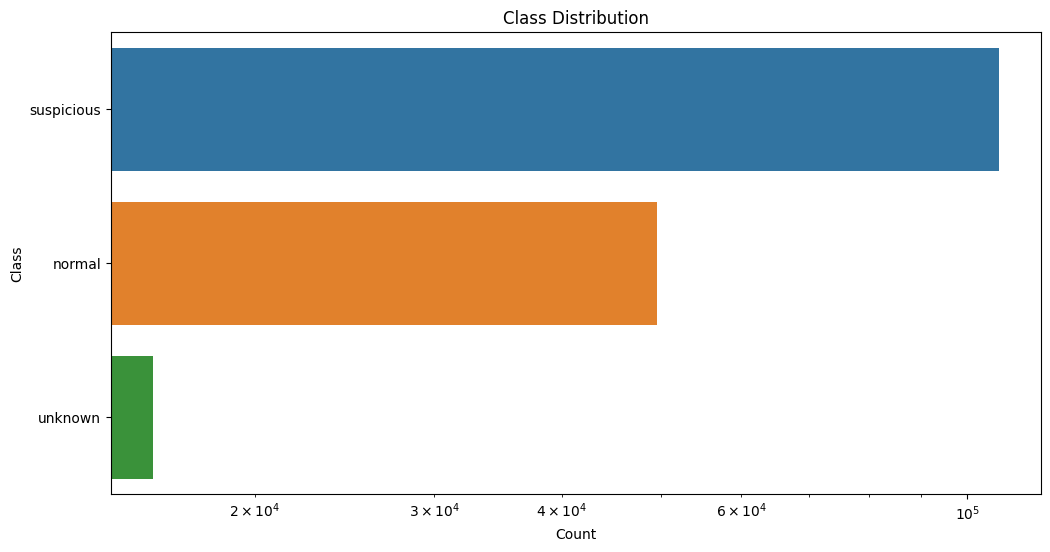

In [130]:
# Visualization of Label Distribution

import seaborn as sns
import matplotlib.pyplot as plt

def visualize_class_distribution(df):
    """
    Generate a countplot to visualize the distribution of class in the dataframe.

    Parameters:
    - df: The dataframe containing class information.
    """
    # Print the count of respective class entries
    print ("Counting the respective class entries:", df['class'].value_counts())

    # Generate a countplot for class distribution (excluding 'BENIGN')
    plt.figure(figsize = (12, 6))
    plot = sns.countplot(data = df, y = 'class', order = df['class'].value_counts().index)
    plt.xscale('log')  # Scale x-axis logarithmically for better visualization
    plt.title('Class Distribution')
    plt.xlabel('Count')
    plt.ylabel('Class')
    plt.show()
    
    # Save the countplot as an image file
    fig = plot.get_figure()
    fig.savefig('class_distribution.png')

    return df
    
df = visualize_class_distribution(df)

In [131]:
def add_flag_columns(dataframe):
    """
    Add new columns for specific flags and set their values based on the presence
    of corresponding flags in the 'Flags' column.

    Parameters:
    - dataframe: The input DataFrame.

    Returns:
    - The DataFrame with added flag columns.
    """
    # Initialize new columns with zeros
    dataframe["A"] = 0
    dataframe["P"] = 0
    dataframe["S"] = 0
    dataframe["R"] = 0
    dataframe["F"] = 0
    dataframe["x"] = 0

    def set_flag(row, check):
        """
        Check if a specific flag is present in the 'Flags' column of a row.

        Parameters:
        - row: A row of the DataFrame.
        - check: The flag to check.

        Returns:
        - 1 if the flag is present, 0 otherwise.
        """
        return 1 if check in row["flags"] else 0

    # Set values in new columns based on the presence of corresponding flags
    dataframe["A"] = dataframe.apply(lambda row: set_flag(row, 'A'), axis=1)
    dataframe["P"] = dataframe.apply(lambda row: set_flag(row, 'P'), axis=1)
    dataframe["S"] = dataframe.apply(lambda row: set_flag(row, 'S'), axis=1)
    dataframe["R"] = dataframe.apply(lambda row: set_flag(row, 'R'), axis=1)
    dataframe["F"] = dataframe.apply(lambda row: set_flag(row, 'F'), axis=1)
    dataframe["x"] = dataframe.apply(lambda row: set_flag(row, 'x'), axis=1)

    return dataframe

# Example usage:
# Assuming df is your DataFrame
df = add_flag_columns(df)


In [132]:
from sklearn.preprocessing import LabelEncoder

def label_encode_categorical_features(df):
    """
    Label encode only the categorical features in the DataFrame.

    Parameters:
    - df: The dataframe containing the dataset.

    Returns:
    - The dataframe with label-encoded categorical features.
    """
    # Create a new dataframe to avoid modifying the original dataframe
    df_encoded = df.drop(['class'], axis = 1)

    # Iterate through each column in the dataframe
    for column in df_encoded.columns:
        # Check if the column dtype is 'object' (categorical)
        if df_encoded[column].dtype == 'object':
            # Use LabelEncoder to encode the categorical column
            label_encoder = LabelEncoder()
            df_encoded[column] = label_encoder.fit_transform(df_encoded[column])
            
    # Concatenate the 'class' column to the encoded dataframe
    df_final = pd.concat([df_encoded, df['class']], axis=1)
    
    return df_final

# Example usage:
# Assuming 'df' is your DataFrame
df = label_encode_categorical_features(df)
df.head()

,date_first_seen,duration,proto,src_ip_addr,src_pt,dst_ip_addr,dst_pt,packets,bytes,flags,A,P,S,R,F,x,class
0,2,81412.697,2,10537,8082,10477,56978.0,3057,4593,20,1,1,0,0,0,0,normal
1,2,81412.697,2,10538,56978,10476,8082.0,4748,4595,20,1,1,0,0,0,0,normal
2,0,81504.787,2,10537,8082,10477,56979.0,8639,4640,20,1,1,0,0,0,0,normal
3,0,81504.787,2,10538,56979,10476,8082.0,12024,4648,20,1,1,0,0,0,0,normal
4,4,82100.692,2,10537,8082,10477,51649.0,11012,4676,21,1,1,1,0,0,0,normal


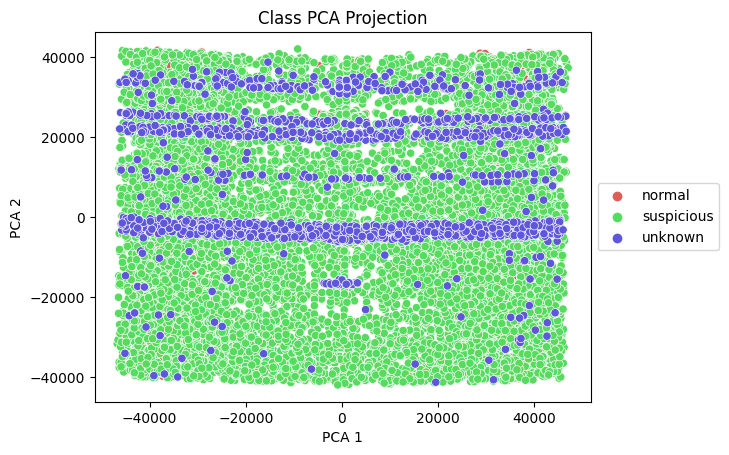

In [133]:
# Exploratory Data Analysis (EDA) with PCA 2D Visualization

# Import necessary libraries
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

def multiclass_pca_projection(df):
    """
    Perform PCA on the subsampled dataset and visualize the multiclass 2D PCA projection.

    Parameters:
    - df: The dataframe containing the dataset.

    Note: Subsamples the dataset (10% sample from each class) for efficient visualization.
    """
    # Subsample the dataset for efficient EDA (10% sample from each class)
    subsample_df = df.groupby('class').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)

    # Extract features and labels
    X = subsample_df.drop(['class'], axis = 1)
    y = subsample_df['class']

    # Apply PCA for dimensionality reduction to 2D
    pca = PCA(n_components = 2, random_state = 0)
    z = pca.fit_transform(X)

    # Create a DataFrame for the 2D PCA representation
    pca_df = pd.DataFrame()
    pca_df['class'] = y
    pca_df['PCA 1'] = z[:, 0]
    pca_df['PCA 2'] = z[:, 1]

    # Visualize the 2D PCA representation with a scatter plot (multiclass)
    sns.scatterplot(data = pca_df, x = 'PCA 1', y = 'PCA 2', hue = 'class', palette = sns.color_palette('hls', len(pca_df['class'].value_counts()))).set_title("Class PCA Projection")

    # Add legend and display the plot
    plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    plt.show()

multiclass_pca_projection(df)

In [134]:
df = df.drop(columns = ['date_first_seen', 'flags'])


In [135]:
df.head()

,duration,proto,src_ip_addr,src_pt,dst_ip_addr,dst_pt,packets,bytes,A,P,S,R,F,x,class
0,81412.697,2,10537,8082,10477,56978.0,3057,4593,1,1,0,0,0,0,normal
1,81412.697,2,10538,56978,10476,8082.0,4748,4595,1,1,0,0,0,0,normal
2,81504.787,2,10537,8082,10477,56979.0,8639,4640,1,1,0,0,0,0,normal
3,81504.787,2,10538,56979,10476,8082.0,12024,4648,1,1,0,0,0,0,normal
4,82100.692,2,10537,8082,10477,51649.0,11012,4676,1,1,1,0,0,0,normal


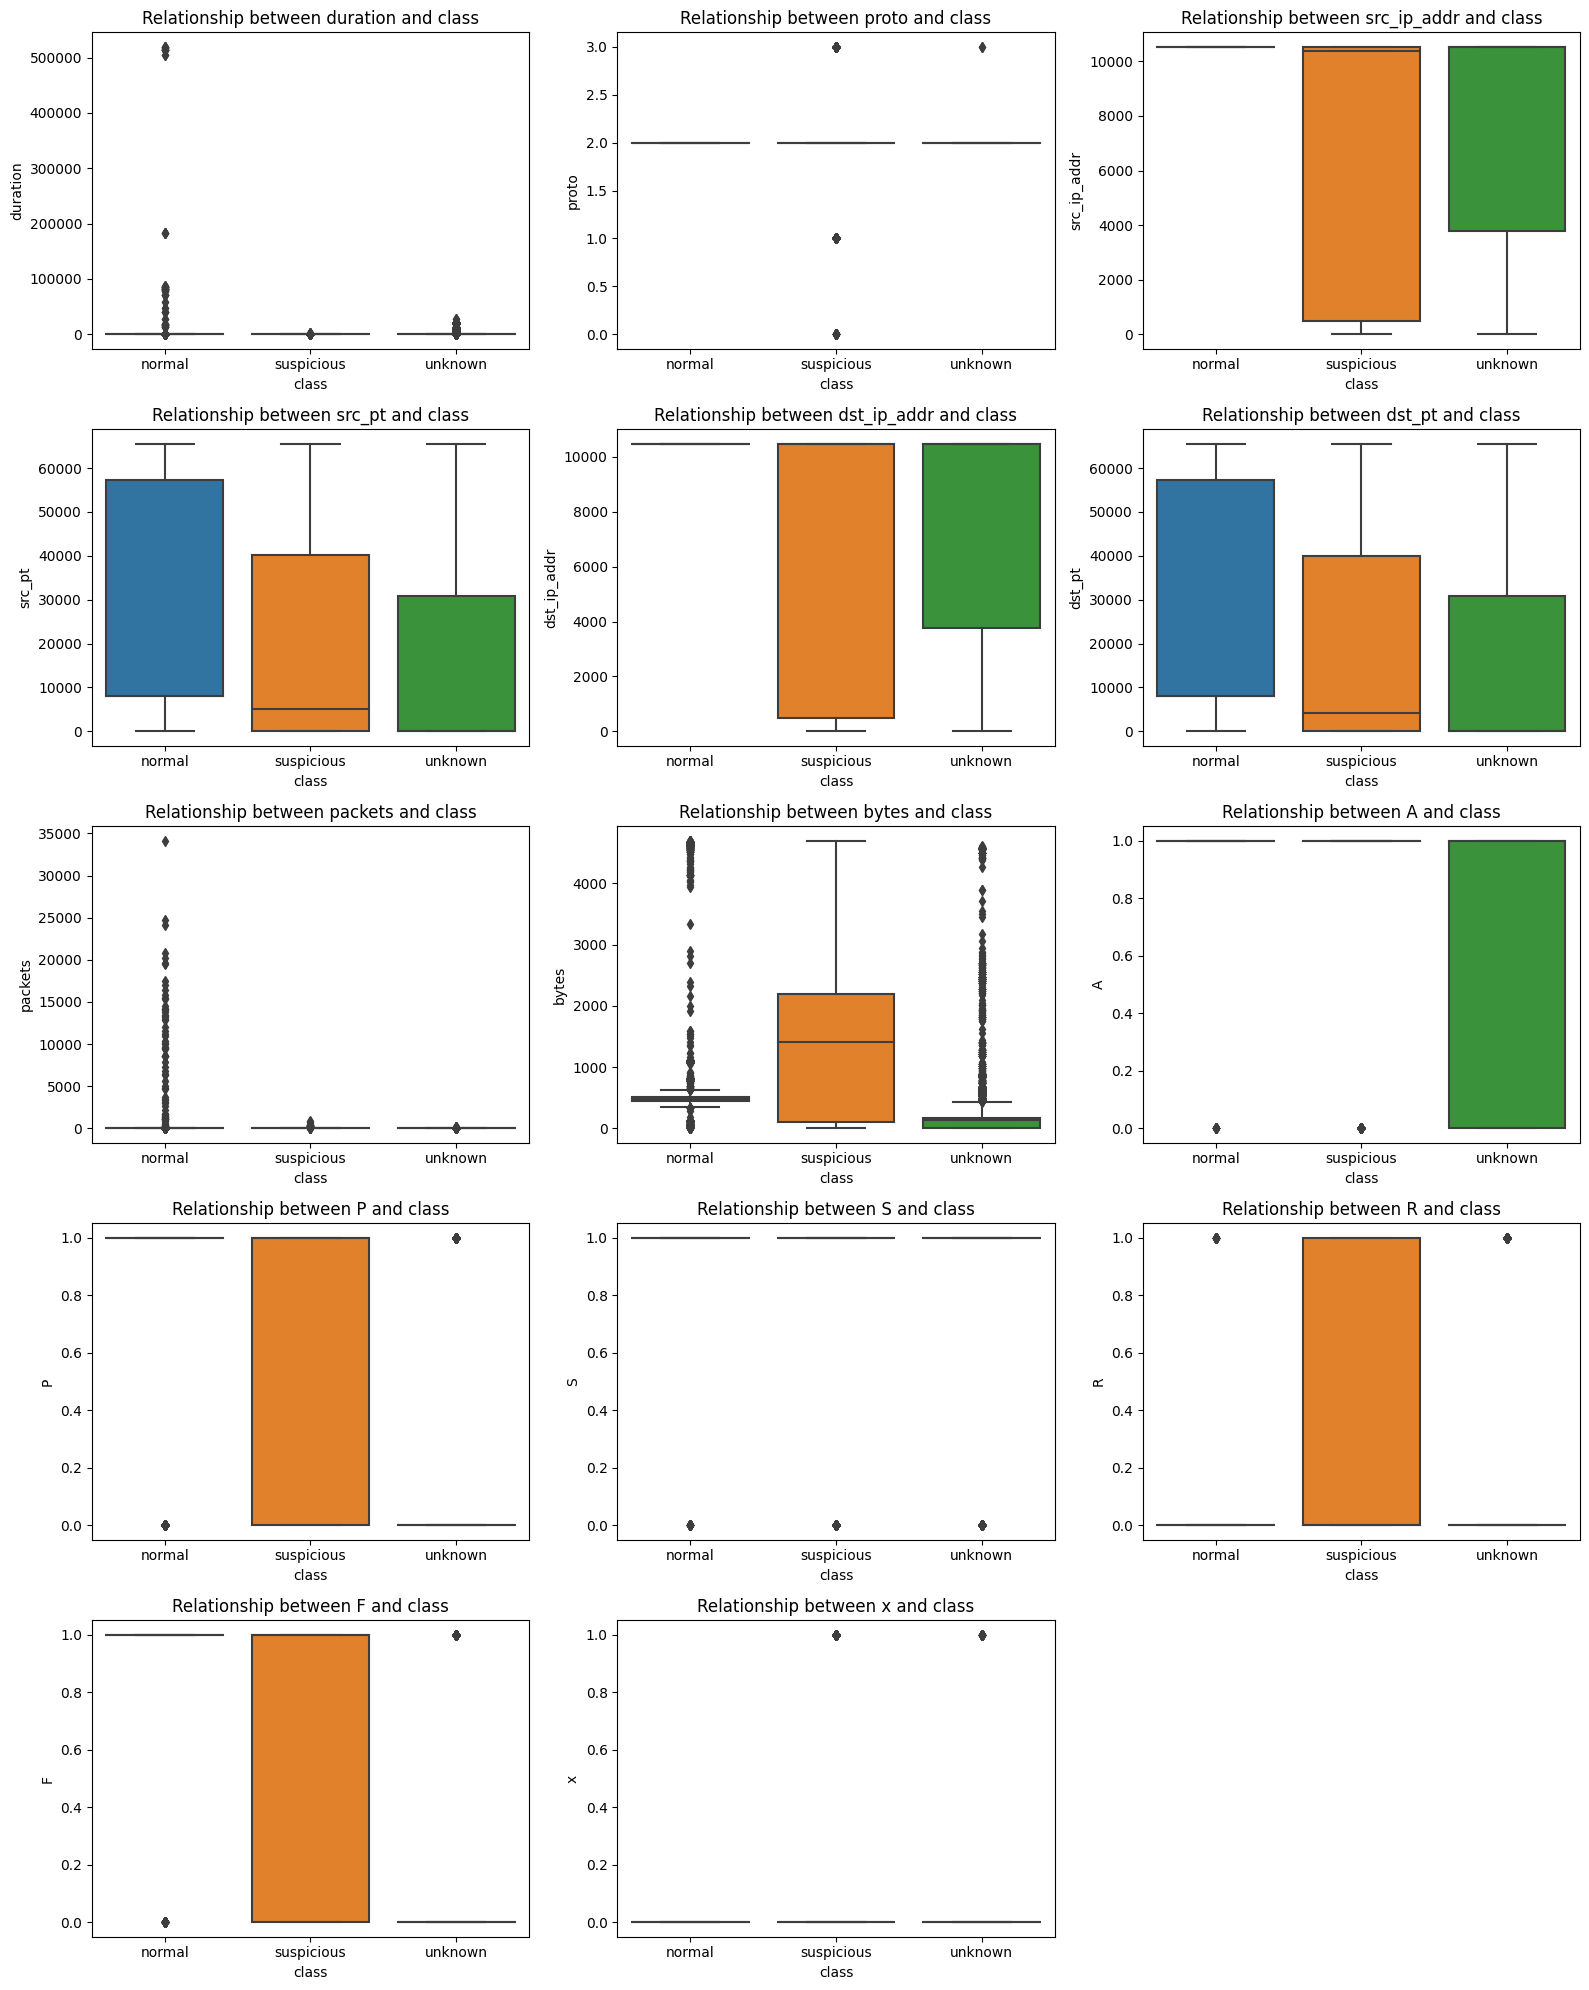

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_feature_class_relationship(df, class_column):
    """
    Visualize the relationship between each feature in the dataset and the specified class.

    Parameters:
    - df: The dataframe containing the dataset.
    - class_column: The column name representing the class.

    Note: The function generates box plots (or violin plots) for each feature grouped by the class.
    """
    # Calculate the number of rows and columns for subplots
    num_features = len(df.columns[ : -1])  # Exclude the last column assumed to be the class column
    num_cols = 3  # You can adjust the number of columns based on your preference
    num_rows = -(-num_features // num_cols)  # Ceiling division to get the number of rows

    # Set the overall size of the figure
    plt.figure(figsize = (16, 4 * num_rows))

    # Iterate through each feature in the DataFrame
    for i, column in enumerate(df.columns[ : -1]):  # Exclude the last column assumed to be the class column
        # Create a box plot for the current feature grouped by class
        plt.subplot(num_rows, num_cols, i + 1)
        sns.boxplot(x = class_column, y = column, data = df)
        
        # Set the plot title
        plt.title(f'Relationship between {column} and {class_column}')

    # Adjust layout to prevent overlap of subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# Assuming 'class' is the column containing class information
# Assuming 'df' is your DataFrame
visualize_feature_class_relationship(df, class_column = 'class')


In [137]:
# Importing needed libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

def split_data(X, y, test_size=0.2):
    """
    Split the dataset into training and testing sets.

    Parameters:
    - X: Features.
    - y: Classes.
    - test_size: Proportion of the dataset to include in the test split.

    Returns:
    - X_train: Training set features.
    - X_test: Test set features.
    - y_train: Training set classes.
    - y_test: Test set classes.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    print(X_train.shape, " ", X_test.shape)
    print(y_train.shape, " ", y_test.shape)
    return X_train, X_test, y_train, y_test

def scale_data(X_train, X_test):
    """
    Apply MinMaxScaler to the training set and transform the test set.

    Parameters:
    - X_train: Training set features.
    - X_test: Test set features.

    Returns:
    - X_train_scaled: Scaled training set features.
    - X_test_scaled: Scaled test set features.
    """
    scaler = MinMaxScaler()

    # Fit and transform the training set
    X_train_scaled = scaler.fit_transform(X_train)

    # Transform the test set using the same scaler
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

def encode_classes(y_train, y_test):
    """
    Encode classes using LabelEncoder and keep track of class names.

    Parameters:
    - y_train: Classes in the training set.
    - y_test: Classes in the testing set.

    Returns:
    - y_train_encoded: Encoded classes in the training set.
    - y_test_encoded: Encoded classes in the testing set.
    - class_mapping: Dictionary mapping class names to their corresponding numeric values.
    """
    # Initialize LabelEncoder
    class_encoder = LabelEncoder()

    # Encode classes in the training set
    y_train_encoded = class_encoder.fit_transform(y_train)

    # Encode classes in the testing set
    y_test_encoded = class_encoder.transform(y_test)

    # Create a dictionary mapping class names to numeric values
    class_mapping = {class_name: encoded_value for class_name, encoded_value in zip(class_encoder.classes_, class_encoder.transform(class_encoder.classes_))}
    print (class_mapping.items())
    # Assuming y_train and y_test are the original class arrays
    # Assuming class_mapping, y_train_encoded, and y_test_encoded are already computed

    # Printing the top 5 instances in the training set
    print("Top 50 instances in the training set:")
    for original_class, encoded_class in zip(y_train[:50], y_train_encoded[:50]):
        print(f"Original Class: {original_class}, Encoded Class: {encoded_class}")

    # Printing the top 5 instances in the testing set
    print("\nTop 50 instances in the testing set:")
    for original_class, encoded_class in zip(y_test[:50], y_test_encoded[:50]):
        print(f"Original Class: {original_class}, Encoded Class: {encoded_class}")

    # Printing the class mapping
    print("\nClass Mapping:")
    for class_name, encoded_value in class_mapping.items():
        print(f"Original Class: {class_name}, Encoded Class: {encoded_value}")

    return y_train_encoded, y_test_encoded, class_mapping


def apply_pca(X_train, X_test):
    """
    Apply PCA to the scaled features and plot explained variance ratio.

    Parameters:
    - X_train: Scaled training set features.
    - X_test: Scaled test set features.

    Returns:
    - X_train_pca: Transformed training set features after PCA.
    - X_test_pca: Transformed test set features after PCA.
    """
    pca = PCA()

    # Fit and transform the training set
    X_train_pca = pca.fit_transform(X_train)

    # Plot the explained variance ratio
    plt.figure(figsize = (10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
    plt.title('Explained Variance Ratio - Cumulative')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.grid(True)
    plt.show()

    # Determine the optimal number of components (capturing 95% of the variance)
    n_components_pca = len(pca.explained_variance_ratio_[pca.explained_variance_ratio_.cumsum() < 0.95])
    print("The number of principal components explaining 95% of information:", n_components_pca)

    # Apply PCA with the selected number of components
    pca = PCA(n_components=n_components_pca)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_test_pca


def balance_data_with_smote_and_undersample(X_train, y_train, sampling_strategy='auto'):
    """
    Balance the dataset by using SMOTE for oversampling and RandomUnderSampler for undersampling.

    Parameters:
    - X_train: Training set features.
    - y_train: Training set classes.
    - sampling_strategy: Strategy to balance the dataset. 'auto' means equalizing the number of samples in each class.

    Returns:
    - X_train_balanced: Balanced training set features.
    - y_train_balanced: Balanced training set classes.
    """
    # Create a pipeline for combining SMOTE and RandomUnderSampler
    pipeline = make_pipeline(SMOTE(sampling_strategy=sampling_strategy), RandomUnderSampler(sampling_strategy=sampling_strategy))

    # Fit and transform the training set using the pipeline
    X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)

    return X_train_balanced, y_train_balanced


In [138]:
def train_classifier(model, X_train, y_train):
    """
    Train a specified classifier on the scaled and balanced data.

    Parameters:
    - model: The classifier model to be trained.
    - X_train: Scaled and balanced training set features.
    - y_train: Scaled and balanced training set labels.

    Returns:
    - model: Trained classifier model.
    """
    print("Training started for " + str(model))
    model.fit(X_train, y_train)
    print("\nTraining completed!")

    return model

In [139]:
from datetime import datetime

def get_key_by_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    # If the value is not found, you may choose to return a default value or raise an exception.
    return None  # or raise ValueError("Value not found in the dictionary")

def evaluate_model_and_save(model, X_test, y_test, label_mapping, classifier_name="classifier", output_folder="./"):
    """
    Evaluate a classification model using various metrics, visualize the confusion matrix,
    and save all output to a file.

    Parameters:
    - model: The trained classifier.
    - X_test: Test set features.
    - y_test: True labels for the test set.
    - label_mapping: Dictionary mapping label names to their corresponding numeric values.
    - classifier_name: Name of the classifier for filename.
    - output_folder: Folder path to save the output files.

    Returns:
    - accuracy: Accuracy of the model.
    - classification_rep: Classification report.
    """
    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, zero_division=1)

    # Generate a timestamp for filename uniqueness
    timestamp = datetime.now().strftime("%d%m%Y%H%M%S")

    # Formulate the output file path with the classifier name
    output_file_path = f"{output_folder}/{classifier_name}_evaluation_{timestamp}.txt"

    # Open the file for writing
    with open(output_file_path, "w") as output_file:
        # Write evaluation metrics to the file
        output_file.write(f"\nAccuracy: {accuracy:.2f}\n")
        output_file.write("Classification Report:\n")
        output_file.write(f"{classification_rep}\n")
        output_file.write(f"The Accuracy of the Model is {accuracy_score(y_test, y_pred)}\n")
        output_file.write(f"The Precision of the Model is {f1_score(y_test, y_pred, average='weighted')}\n")
        output_file.write(f"The Recall of the Model is {precision_score(y_test, y_pred, average='weighted')}\n")
        output_file.write(f"The F1 Score of the Model is {recall_score(y_test, y_pred, average='weighted')}\n")

        # Visualize the confusion matrix and save the plot
        plt.figure(figsize=(15, 15))
        confusion_matrix_data = confusion_matrix(y_test, y_pred)
        sns.heatmap(confusion_matrix_data, annot=True)
        plt.savefig(f"{output_folder}/{classifier_name}_confusion_matrix_{timestamp}.png")
        plt.close()

        # Write the confusion matrix path to the file
        output_file.write(f"\nConfusion Matrix saved as {classifier_name}_confusion_matrix_{timestamp}.png\n")

        # Print the top 100 instances with actual and predicted labels using label names
        output_file.write("\nTop 50 instances with actual and predicted labels:\n")
        for i in range(50):
            actual_label_name = get_key_by_value(label_mapping, y_test[i])
            predicted_label_name = get_key_by_value(label_mapping, y_pred[i])
            output_file.write(f"Instance {i + 1}: Actual Label - {actual_label_name}, Predicted Label - {predicted_label_name}\n")

    print(f"Output saved to {output_file_path}")

    return accuracy, classification_rep


(138270, 14)   (34568, 14)
(138270,)   (34568,)
dict_items([('normal', 0), ('suspicious', 1), ('unknown', 2)])
Top 50 instances in the training set:
Original Class: suspicious, Encoded Class: 1
Original Class: normal, Encoded Class: 0
Original Class: unknown, Encoded Class: 2
Original Class: suspicious, Encoded Class: 1
Original Class: normal, Encoded Class: 0
Original Class: normal, Encoded Class: 0
Original Class: suspicious, Encoded Class: 1
Original Class: normal, Encoded Class: 0
Original Class: suspicious, Encoded Class: 1
Original Class: suspicious, Encoded Class: 1
Original Class: normal, Encoded Class: 0
Original Class: normal, Encoded Class: 0
Original Class: suspicious, Encoded Class: 1
Original Class: suspicious, Encoded Class: 1
Original Class: normal, Encoded Class: 0
Original Class: normal, Encoded Class: 0
Original Class: normal, Encoded Class: 0
Original Class: normal, Encoded Class: 0
Original Class: suspicious, Encoded Class: 1
Original Class: normal, Encoded Class: 

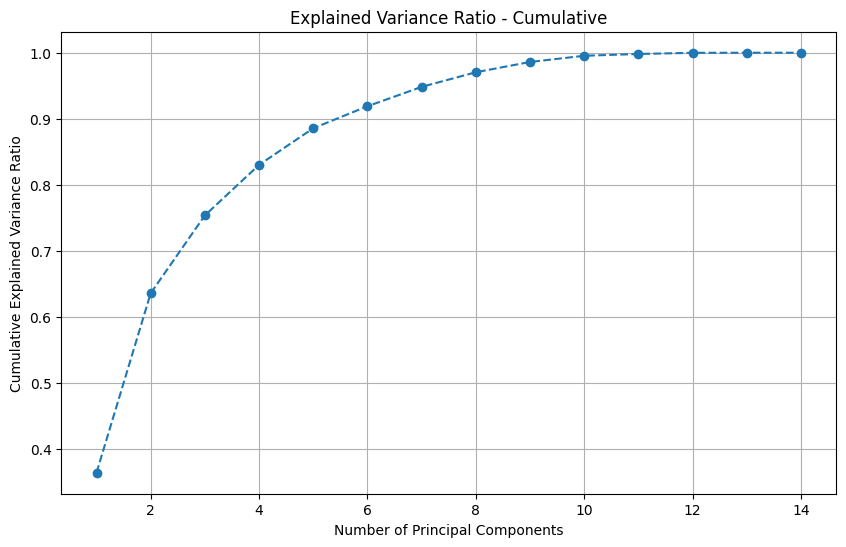

The number of principal components explaining 95% of information: 7


In [140]:
# Calling functions 

# visualize_dataframe(df)
# visualize_dataframe(df)

# Preprocessing dataset
# df = data_preprocessing(df)

# Visualization of Class Distribution
# visualize_class_distribution(df)

# Call the multiclass_pca_projection function
# multiclass_pca_projection(df)

# Assuming X and y are your features and labels
X = df.drop(columns = 'class')
y = df['class']

# Split the data
X_train, X_test, y_train, y_test = split_data(X, y)

# Scale the data
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

# Encode train and test class labels
y_train_encoded, y_test_encoded, label_mapping = encode_classes(y_train, y_test)

# Apply PCA
X_train_pca, X_test_pca = apply_pca(X_train_scaled, X_test_scaled)

# Balance the data with SMOTE
# X_train_balanced, y_train_balanced = balance_data_with_smote(X_train_pca, y_train)

In [141]:
model = train_classifier(RandomForestClassifier(), X_train_pca, y_train_encoded) #Random Forest


Training started for RandomForestClassifier()

Training completed!


In [142]:
evaluate_model_and_save(model, X_test_pca, y_test_encoded, label_mapping, classifier_name = "random_forest", output_folder = "./")


Output saved to .//random_forest_evaluation_09012024145012.txt


(0.9927389493172877,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      9952\n           1       0.99      0.99      0.99     21500\n           2       0.97      0.96      0.96      3116\n\n    accuracy                           0.99     34568\n   macro avg       0.99      0.98      0.98     34568\nweighted avg       0.99      0.99      0.99     34568\n')